<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
     <img style="float: right; padding-right: 10px" width="100" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>
     </div>

**Clemson University**<br>
**Instructor(s):** Aaron Masino <br>

## Lab 8: Convolutional Neural Networks

This lab will introduce you to the creation, training, and evaluation of convolutional neural network models using the [PyTorch](https://pytorch.org/) and [PyTorch Lightning](https://lightning.ai/pytorch-lightning) libraries. PyTorch contains core capabilities related to the development of deep learning models. PyTorch Lightning provides functionally that abstracts much of the process of training and evaluating deep learning models created with PyTorch.

By the end of this lab, you should be able to:
- Evaluate convolution output dimensions using PyTorch Conv2D
- Apply PyTorch Conv2D and CNN concepts to build image classification models
- Evaluate CNN image classification model performance

In [1]:
!pip install lightning huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.7 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.functional as F

import lightning as L
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import torchmetrics as TM

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

In [3]:
# Google Colab setup
# mount the google drive - this is necessary to access supporting src
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


We will use a hugging face hub dataset for this lab which requires installation of the `huggingface_hub` Python package. To install this package in your Conda environment execute the following cell:

In [4]:
def create_data_directory(path: str):
    if not os.path.exists(path):
        os.makedirs(path)

dir_dataroot = os.path.join("..", "data")
create_data_directory(dir_dataroot)

dir_lightning = os.path.join("..", "lightning")
create_data_directory(dir_lightning)

SEED = 123456

Execute the following cell to set the `device` variable to the appropriate accelerator for your environment. NOTE: this lab notebook will run extremely slowly without GPU support.

In [5]:
# set device variable to cuda or mps if available otherwise cpu
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

# Part 1 Image Classification with Convolutional Neural Networks

## CIFAR10 DataSet
In part 1 of this lab, we will work with the CIFAR10 dataset which contains color images that are labeled with one of ten possible class labels. Let's begin by loading the data.

In [6]:

cifar10_train_all = CIFAR10(root=dir_dataroot, train=True, download=True, transform=ToTensor())
cifar10_test = CIFAR10(root=dir_dataroot, train=False, download=True, transform=ToTensor())

100%|██████████| 170M/170M [00:05<00:00, 29.8MB/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Let's view some examples of the images. Notice that they have already been scaled to a fixed size and normalized.

imgs.shape =  torch.Size([8, 3, 32, 32])


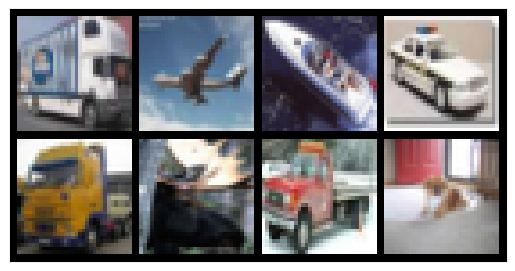

In [7]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

batch_size = 8
# we can create a DataLoader using the
imgs = next(iter(DataLoader(cifar10_train_all, batch_size=batch_size, shuffle=True)))[0]
print('imgs.shape = ', imgs.shape)
grid = make_grid(imgs, nrow=4)
show(grid)

We note that each image is a _Red_, _Green_, _Blue_ (RGB) image. Thus each image contains three channels and the Tensor holding the image data will have three input channels. Let's look at each of the channels below for a sample image.

img_channels.shape =  torch.Size([3, 1, 32, 32])


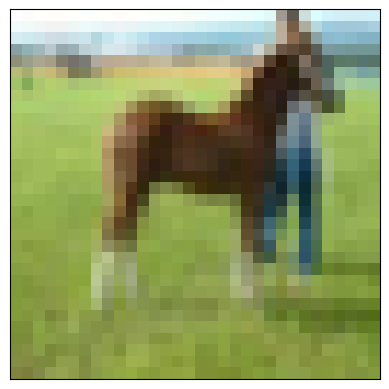

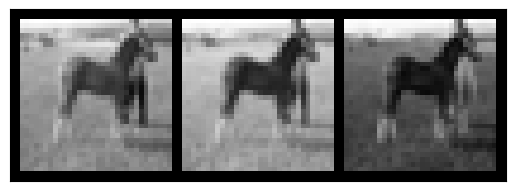

In [8]:
batch_size = 1
# we can create a DataLoader using the
imgs = next(iter(DataLoader(cifar10_train_all, batch_size=batch_size, shuffle=True)))[0]
# imgs = imgs.squeeze(0)
img_channels = torch.zeros(3,1,32,32)
for i in range(imgs.shape[1]):
    img_channels[i] = imgs[0,i]

print('img_channels.shape = ', img_channels.shape)
grid = make_grid(imgs, nrow=4)
show(grid)
grid = make_grid(img_channels, nrow=4)
show(grid)

## Convolution Module
Before we build our CNN models, let's first explore the convolution operation on images and mini-batches of images using the PyTorch `nn.Conv2d` module. This module will perform the convolution operation using a selected number of kernels of a specified size. It will be important to understand the dimensions that result.

In [9]:
n_input_channels = 1
n_kernels = 10
n_output_channels = 1 # this is the number of kernels / filters in the convolutional layer
sample1 = torch.randn(1, n_input_channels, 32, 32)
sample2 = torch.randn(1, n_input_channels, 16, 16)
conv = nn.Conv2d(in_channels=n_input_channels, out_channels=n_kernels, kernel_size=3, padding=0)

print('sample1.shape = ', sample1.shape)
print('sample2.shape = ', sample2.shape)
print('conv(sample1).shape = ', conv(sample1).shape)
print('conv(sample2).shape = ', conv(sample2).shape)

sample1.shape =  torch.Size([1, 1, 32, 32])
sample2.shape =  torch.Size([1, 1, 16, 16])
conv(sample1).shape =  torch.Size([1, 10, 30, 30])
conv(sample2).shape =  torch.Size([1, 10, 14, 14])


In [10]:
n_input_channels = 3
sample_dim = 32
batch_size = 2
sample = torch.randn(batch_size, n_input_channels, sample_dim, sample_dim)
n_kernels = 10
conv = nn.Conv2d(in_channels=n_input_channels, out_channels=n_kernels, kernel_size=3, padding=0)
print('sample.shape = ', sample.shape)
print('conv.weight.shape = ', conv.weight.shape)
print('conv(sample).shape = ', conv(sample).shape)

sample.shape =  torch.Size([2, 3, 32, 32])
conv.weight.shape =  torch.Size([10, 3, 3, 3])
conv(sample).shape =  torch.Size([2, 10, 30, 30])


What if we want to reduce the number of output channels without reducing the image (or embedding space) dimensions? We can use kernels of size 1.

In [11]:
n_input_channels = 3
sample_dim = 32
batch_size = 2
sample = torch.randn(batch_size, n_input_channels, sample_dim, sample_dim)
n_kernels = 20
conv1 = nn.Conv2d(in_channels=n_input_channels, out_channels=n_kernels, kernel_size=3, padding=0)
conv_image = conv1(sample)
print('sample.shape = ', sample.shape)
print('conv.weight.shape = ', conv.weight.shape)
print('conv(sample).shape = ', conv_image.shape)

conv2 = nn.Conv2d(in_channels=n_kernels, out_channels=5, kernel_size=1, padding=0)
print('conv2.weight.shape = ', conv2.weight.shape)
print('conv2(sample).shape = ', conv2(conv_image).shape)

sample.shape =  torch.Size([2, 3, 32, 32])
conv.weight.shape =  torch.Size([10, 3, 3, 3])
conv(sample).shape =  torch.Size([2, 20, 30, 30])
conv2.weight.shape =  torch.Size([5, 20, 1, 1])
conv2(sample).shape =  torch.Size([2, 5, 30, 30])


So far we have created randomly initialized filters. We don't expect them to correspond to any particular patterns. Rather, they should essentially downsample the image. Let's look at images after passing through a single random filter.

torch.Size([1, 5, 30, 30])


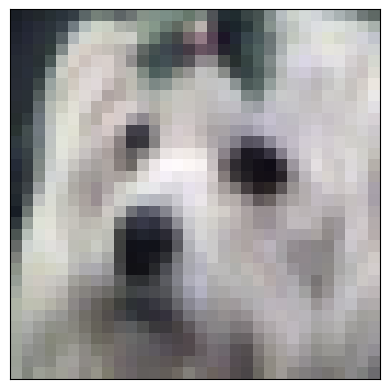

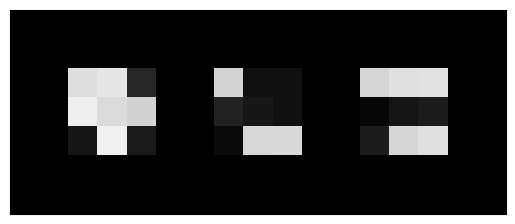

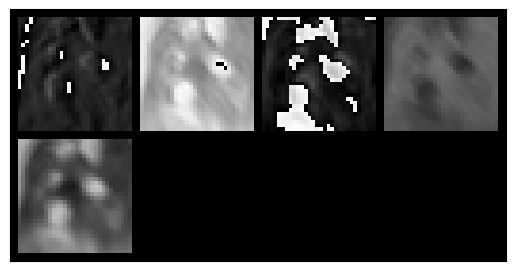

In [12]:
imgs = next(iter(DataLoader(cifar10_train_all, batch_size=1, shuffle=True)))[0]
grid = make_grid(imgs, nrow=4)
show(grid)

ks = 3 # kernel size
filters = torch.zeros(3,1,ks, ks)
for i in range(3):
    filters[i] = conv.weight[0,i]
grid = make_grid(filters, nrow=4)
show(grid)

conv = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=ks, padding=0)
img_conv = conv(imgs)
print(img_conv.shape)
grid = make_grid(img_conv.permute(1,0,2,3), nrow=4)
show(grid)

## Classification Model
We are now ready to contruct the modules that we will use to create our CNN image classification model. First, we need to load the data and split into train, validation, and test sets.

In [13]:
seed_everything(SEED)
batch_size = 32

val_split = 0.2
val_size = int(len(cifar10_train_all) * val_split)
train_size = len(cifar10_train_all) - val_size
cifar10_train, cifar10_val = torch.utils.data.random_split(cifar10_train_all, [train_size, val_size])
cifar10_train_all_targets = torch.tensor(cifar10_train_all.targets)
cifar10_test_targets = torch.tensor(cifar10_test.targets)

INFO: Seed set to 123456
INFO:lightning.fabric.utilities.seed:Seed set to 123456


In [14]:
print("Training samples:",cifar10_train_all.data[cifar10_train.indices].shape)
print("Unique classes in training:",cifar10_train_all_targets[cifar10_train.indices].unique())

print("\nValidation samples:", cifar10_train_all.data[cifar10_val.indices].shape)
print("Unique classes in validation:", cifar10_train_all_targets[cifar10_val.indices].unique())

print("\nTest samples:", cifar10_test.data.shape)
print(cifar10_test_targets.unique())

Training samples: (40000, 32, 32, 3)
Unique classes in training: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Validation samples: (10000, 32, 32, 3)
Unique classes in validation: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Test samples: (10000, 32, 32, 3)
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


Next, let's create data loaders that we will use in our PyTorch Lightning Trainer module.

In [15]:
# create the dataloaders
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(cifar10_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

Let's begin by creating a class that will _encode_ input images using a `Conv2d` layer to perform convolution followed by a `MaxPool2d` layer (for max pooling of the output from the Conv2D) and then a `ReLU` nonlinear activation.

In [16]:
class CIFAR10Encoder(nn.Module):
    def __init__(self, num_channels, num_kernels, kernel_size=3, stride=1, padding=0):
        super().__init__()
        self.encoder = nn.Sequential(
            # input has 1 channel
            nn.Conv2d(num_channels, num_kernels, kernel_size=kernel_size, stride=stride, padding=padding),  # conv2d layer
            nn.MaxPool2d(kernel_size=2, stride=2),                 # max pooling layer with kernel size 2x2
            nn.ReLU()                                             # ReLU activation function
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

# Test the ImageEncoder with random input data
num_kernels = 50
encoder = CIFAR10Encoder(3, num_kernels)
input_image = torch.randn(1, 3, 32,32)  # batch_size x channels x height x width
output_features = encoder(input_image)
print("Output shape:", output_features.shape)

Output shape: torch.Size([1, 50, 15, 15])


Next, let's construct the fully connected linear layer which will used to generate our class logits.

In [17]:
class CIFAR10Output(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()  # Flatten the input tensor
        self.linear = nn.Linear(input_dim, num_classes)  # Linear layer with 10 output units

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input tensor
        x = self.linear(x)   # Pass through the linear layer
        return x

# Test the module with random input data
decoder = CIFAR10Output(num_kernels*15*15, 10)
input_tensor = torch.randn(5, num_kernels, 15, 15)  # Batch size of 5, input tensor shape [5, 32, 7, 7]
rslt = decoder(input_tensor)
print("Rslt shape:", rslt.shape)  # Expected output shape: [5, 10]
print(rslt.dtype)

Rslt shape: torch.Size([5, 10])
torch.float32


Now we can build build our image classiication model by extending the PyTorch LightningModule class. This code is nearly identical to the model we build in the previous lab notebook.

In [ ]:
class CIFAR10Classifier(L.LightningModule):
    def __init__(self, encoder, decoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

       # validation metrics - we will use these to compute the metrics at the end of the validation epoch
        self.val_metrics_tracker = TM.wrappers.MetricTracker(TM.MetricCollection([TM.classification.MulticlassAccuracy(num_classes=num_classes)]), maximize=True)
        self.validation_step_outputs = []
        self.validation_step_targets = []

        # test metrics - we will use these to compute the metrics at the end of the test epoch
        self.test_roc = TM.ROC(task="multiclass", num_classes=num_classes) # roc and cm have methods we want to call so store them in a variable
        self.test_cm = TM.ConfusionMatrix(task='multiclass', num_classes=num_classes)
        self.test_metrics_tracker = TM.wrappers.MetricTracker(TM.MetricCollection([TM.classification.MulticlassAccuracy(num_classes=num_classes),
                                                            self.test_roc, self.test_cm]), maximize=True)

        # test outputs and targets - we will store the outputs and targets for the test step
        self.test_step_outputs = []
        self.test_step_targets = []

    # the forward method applies the encoder and output to the input
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    # the training step. pass the batch through the model and compute the loss
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        # where is our softmax? We don't need it here because we are using cross_entropy which includes the softmax for efficiency
        loss = nn.functional.cross_entropy(logits, y)
        self.log('train_loss', loss)
        return loss

    # the validation step. pass the batch through the model and compute the loss. Store the outputs and targets for the epoch end step and log the loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True)

        # store the outputs and targets for the epoch end step
        self.validation_step_outputs.append(logits)
        self.validation_step_targets.append(y)
        return loss

    # the test step. pass the batch through the model and compute the loss. Store the outputs and targets for the epoch end step and log the loss
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.functional.cross_entropy(logits, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True)
        self.test_step_outputs.append(logits)
        self.test_step_targets.append(y)
        return loss

    # at the end of the epoch compute the metrics
    def on_validation_epoch_end(self):
        # stack all the outputs and targets into a single tensor
        all_preds = torch.vstack(self.validation_step_outputs)
        all_targets = torch.hstack(self.validation_step_targets)

        # compute the metrics
        loss = nn.functional.cross_entropy(all_preds, all_targets)
        self.val_metrics_tracker.increment()
        self.val_metrics_tracker.update(all_preds, all_targets)
        self.log('val_loss_epoch_end', loss)

        # clear the validation step outputs
        self.validation_step_outputs.clear()
        self.validation_step_targets.clear()

    def on_test_epoch_end(self):
        all_preds = torch.vstack(self.test_step_outputs)
        all_targets = torch.hstack(self.test_step_targets)

        self.test_metrics_tracker.increment()
        self.test_metrics_tracker.update(all_preds, all_targets)
        # clear the test step outputs
        self.test_step_outputs.clear()
        self.test_step_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

Now, we can train the model using the PyTorch Trainer class.

In [19]:
seed_everything(SEED)
num_kernels = 50
encoder = CIFAR10Encoder(3, num_kernels)
decoder = CIFAR10Output(num_kernels*15*15, 10)
model = CIFAR10Classifier(encoder, decoder, 10)

trainer = L.Trainer(default_root_dir=dir_lightning,
                    max_epochs=10,
                    callbacks=[EarlyStopping(monitor="val_loss_epoch_end", mode="min", patience=3)],)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO: Seed set to 123456
INFO:lightning.fabric.utilities.seed:Seed set to 123456
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIB

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Let's examine the validation set accuracy.

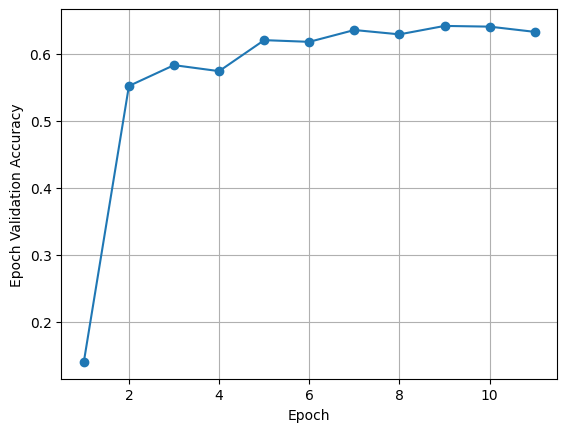

In [20]:
mca = model.val_metrics_tracker.compute_all()['MulticlassAccuracy']
plt.plot(range(1, len(mca)+1), mca, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Epoch Validation Accuracy')
plt.grid()

Let's also look at the classificaiton report on the validation data.

In [21]:
device = torch.device("cpu")   #"cuda:0"
# put the model in evaluation mode so that the parameters are fixed and we don't compute gradients
model.eval()
y_true=[]
y_pred=[]
# use torch.no_grad() to disable gradient computation
with torch.no_grad():
    # iterate over the test loader minibatches
    for val_data in val_loader:
        # get the images and labels from the test loader and move them to the cpu. this will make it easier to use them with sklearn
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        pred = model(val_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(val_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=cifar10_train_all.classes,digits=4))

              precision    recall  f1-score   support

    airplane     0.6737    0.6969    0.6851       960
  automobile     0.7920    0.7429    0.7666      1015
        bird     0.4418    0.5770    0.5004       974
         cat     0.4892    0.4231    0.4538      1021
        deer     0.5012    0.6263    0.5568       966
         dog     0.5249    0.5188    0.5219      1035
        frog     0.7734    0.6382    0.6993       995
       horse     0.6818    0.6769    0.6793       978
        ship     0.7613    0.7664    0.7638      1053
       truck     0.8081    0.6590    0.7260      1003

    accuracy                         0.6324     10000
   macro avg     0.6448    0.6325    0.6353     10000
weighted avg     0.6457    0.6324    0.6357     10000



Our validation set performance is not great. We might do better by adding additional convolution layers. In the cell below, we construct a new encoder module using three successive convolution layers. We will use this to build a new classification model and compare its validation performance to the first model.

In [22]:
class CIFAR10Encoder2(nn.Module):
    def __init__(self, num_channels, num_kernels, kernel_size=3, stride=1, padding=0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

# Test the ImageEncoder with random input data
num_kernels = 32
encoder = CIFAR10Encoder2(3, num_kernels)
input_image = torch.randn(1, 3, 32,32)  # batch_size x channels x height x width
output_features = encoder(input_image)
print("Output shape:", output_features.shape)

Output shape: torch.Size([1, 256, 4, 4])


In the code cell below, we use our new three convolution layer encoder to construct a new model. Notice, we did __not__ need to create a new model class. We only need to create a new instance of our `CIFAR10Classifier` class passing it an instance of our new encoder.

In [23]:
seed_everything(SEED)
num_kernels = 32
encoder = CIFAR10Encoder2(3, num_kernels)
decoder = CIFAR10Output(256*4*4, 10)
model = CIFAR10Classifier(encoder, decoder, 10)

trainer = L.Trainer(default_root_dir=dir_lightning,
                    max_epochs=10,
                    callbacks=[EarlyStopping(monitor="val_loss_epoch_end", mode="min", patience=3)],)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO: Seed set to 123456
INFO:lightning.fabric.utilities.seed:Seed set to 123456
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIB

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

We now examine the validation set performance which is indeed better for the three convolution layer model.

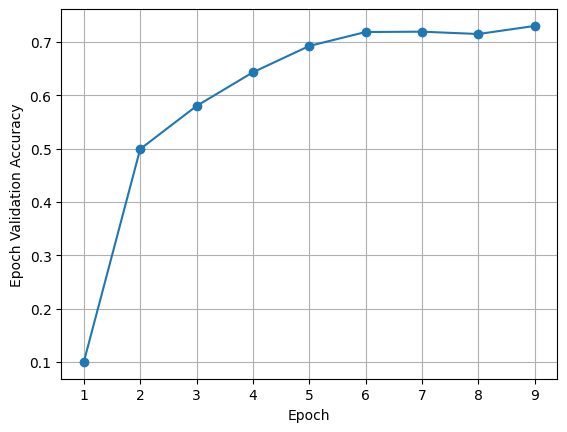

In [24]:
mca = model.val_metrics_tracker.compute_all()['MulticlassAccuracy']
plt.plot(range(1, len(mca)+1), mca, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Epoch Validation Accuracy')
plt.grid()

In [25]:
device = torch.device("cpu")   #"cuda:0"
# put the model in evaluation mode so that the parameters are fixed and we don't compute gradients
model.eval()
y_true=[]
y_pred=[]
# use torch.no_grad() to disable gradient computation
with torch.no_grad():
    # iterate over the test loader minibatches
    for val_data in val_loader:
        # get the images and labels from the test loader and move them to the cpu. this will make it easier to use them with sklearn
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        pred = model(val_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(val_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=cifar10_train_all.classes,digits=4))

              precision    recall  f1-score   support

    airplane     0.7685    0.7469    0.7575       960
  automobile     0.8526    0.8493    0.8509      1015
        bird     0.5986    0.7012    0.6459       974
         cat     0.5516    0.5397    0.5455      1021
        deer     0.7006    0.6418    0.6699       966
         dog     0.6093    0.6329    0.6209      1035
        frog     0.7802    0.7779    0.7791       995
       horse     0.7804    0.7413    0.7604       978
        ship     0.8735    0.8196    0.8457      1053
       truck     0.8128    0.8485    0.8302      1003

    accuracy                         0.7301     10000
   macro avg     0.7328    0.7299    0.7306     10000
weighted avg     0.7331    0.7301    0.7309     10000



Let's examine the performance of our three covolutional layer classification model on the test set.

In [26]:
trainer.test(model=model, dataloaders=test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.9098076224327087     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.9098076224327087}]

Now, let's examine the performanc metrics from the test metrics tracker.

In [27]:
rslt = model.test_metrics_tracker.compute()

Let's examine the confusion matrix

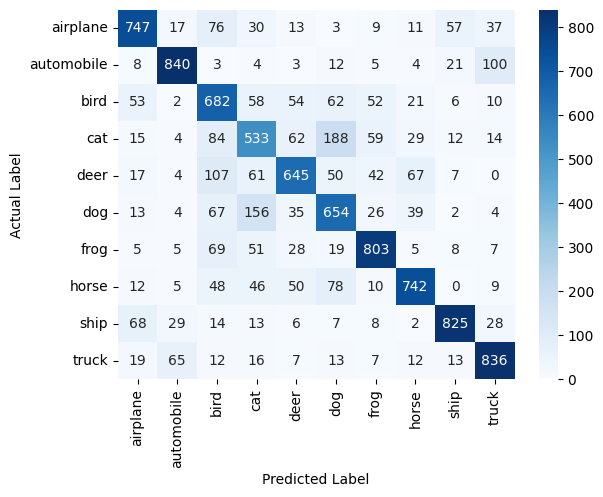

In [28]:
cmp = sns.heatmap(rslt['MulticlassConfusionMatrix'], annot=True, fmt='d', cmap='Blues')
cmp.set_xlabel('Predicted Label')
cmp.set_xticklabels(cifar10_train_all.classes, rotation=90)
cmp.set_yticklabels(cifar10_train_all.classes, rotation=0)
cmp.set_ylabel('Actual Label');

Let's look at teh intra-class ROC results

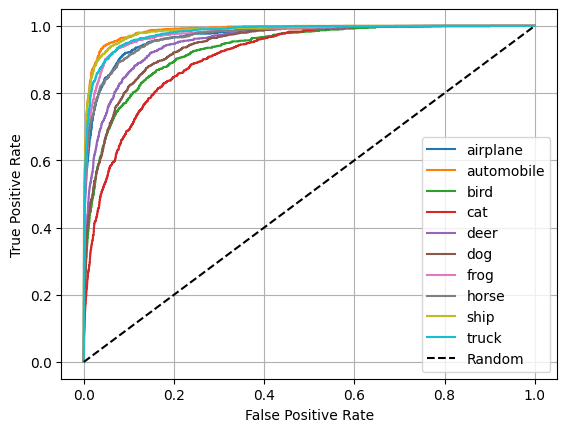

In [29]:
fpr, tpr, thresholds = rslt['MulticlassROC']
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=cifar10_train_all.classes[i])
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()

In [30]:
device = torch.device("cpu")   #"cuda:0"
# put the model in evaluation mode so that the parameters are fixed and we don't compute gradients
model.eval()
y_true=[]
y_pred=[]
# use torch.no_grad() to disable gradient computation
with torch.no_grad():
    # iterate over the test loader minibatches
    for test_data in test_loader:
        # get the images and labels from the test loader and move them to the cpu. this will make it easier to use them with sklearn
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=cifar10_train_all.classes,digits=4))

              precision    recall  f1-score   support

    airplane     0.7806    0.7470    0.7634      1000
  automobile     0.8615    0.8400    0.8506      1000
        bird     0.5869    0.6820    0.6309      1000
         cat     0.5506    0.5330    0.5417      1000
        deer     0.7143    0.6450    0.6779      1000
         dog     0.6022    0.6540    0.6270      1000
        frog     0.7865    0.8030    0.7947      1000
       horse     0.7961    0.7420    0.7681      1000
        ship     0.8675    0.8250    0.8457      1000
       truck     0.8000    0.8360    0.8176      1000

    accuracy                         0.7307     10000
   macro avg     0.7346    0.7307    0.7318     10000
weighted avg     0.7346    0.7307    0.7318     10000

